In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import atecml.data
from tqdm import tqdm

class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,)) 
        oof_test = np.zeros((num_test,))
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        model_list = []
        
        for i in range(0,n_folds):
            
            val_index = DateFold[5] #始终用最后20%验证            
            train_index = list(all_list - DateFold[i])
                            
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            
            #Over_sample
            #X_resampled, y_resampled = SMOTE().fit_sample(x_tra,y_tra)
            #model, auc = self.train(X_resampled, y_resampled, x_val, y_val)
            model, auc = self.train(x_tra, y_tra, x_val, y_val)
            aucs.append(auc)
            model_list.append(model)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test_all_fold[:, i] = self.predict(model, x_test)
        oof_test = np.mean(oof_test_all_fold, axis=1)
        print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test,model_list

import lightgbm as lgb
class LGBClassifier(BasicModel):
    '''
    ' 调参范围
    'num_leaves':range(35,65,5)
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]
    'min_child_weight':range(1,6,2)
    'max_depth':range(3,10,2),
    'subsample':[i/10.0 for i in range(6,10)],正常直接设置为1
    'colsample_bytree':[i/10.0 for i in range(6,10)]，正常直接设置为1
    'reg_alpha','reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,2.5,3]
    '''
    def __init__(self,boost_type,boost_round=1000,early_stop=100,pos_weight=1):
        self.num_boost_round = boost_round
        self.early_stopping_rounds = early_stop
        self.params = {
            'task': 'train',
            'boosting_type': boost_type,
            'colsample_bytree': 0.7,
            'learning_rate': 0.01,
            'max_bin': 511,
            'max_depth': -1,
            'metric': {'auc'},
            'min_child_samples': 20,
            #'min_child_weight': 0.05,
            'min_split_gain': 0,
            'nthread': 40,
            'num_leaves': 80,
            'objective': 'binary',
            #'reg_alpha': 0.01,
            #'reg_lambda': 0.01,
            #'is_unbalance':'true',
            'scale_pos_weight': pos_weight,
            'subsample': 0.85,
            'subsample_for_bin': 200000,
            'subsample_freq': 1,
            'use_missing': 'true',
            'verbose' : -1,
            #'device': 'gpu'
            }
        print(self.params)
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets=lgbval, 
                          verbose_eval = 50,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']['auc']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        return model.predict(x_test, num_iteration=model.best_iteration)

def stack_layer1_result(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        rf_input_list = []
        for idx in tqdm(range(len(rf_model_list))):
            model = rf_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            rf_input_list.append(pd.DataFrame(_temp_df))
        rf_oof_predict= np.array(pd.concat(rf_input_list,ignore_index=True,axis=1).mean(axis=1))    
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    input_predict = [rf_oof_predict, gbdt_oof_predict, dart_oof_predict] 
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict


def stack_layer1_result_wo_rf(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        predict_list = []
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            predict_list.append(_temp_df)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            predict_list.append(_temp_df)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    #input_predict = [ gbdt_oof_predict, dart_oof_predict] 
    input_predict = predict_list
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict,gbdt_oof_predict,dart_oof_predict

In [2]:
train_df = pd.read_pickle('./train.dat')
val_df = atecml.data.load_test()


predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

(634284, 360447)

In [3]:
target='Fraud'
x_train = np.array(train_df[predictors])
y_train = np.array(train_df[target])
x_test = np.array(val_df[predictors])
print(x_train.shape, y_train.shape, x_test.shape)

(994731, 297) (994731,) (500538, 297)


In [4]:
num_pos = np.sum(train_df[target])  
num_neg = x_train.shape[0]- num_pos
scale_pos_weight =  num_pos/num_neg
print(num_pos,num_neg,scale_pos_weight)


13387.0 981344.0 0.013641495744611471


In [5]:
num_boost_round = 1000
num_early_stop = 50

In [6]:
# get output of first layer models and construct as input for the second layer          
rf_classifier = LGBClassifier(boost_type='rf',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
rf_oof_train, rf_oof_test,rf_model_list = rf_classifier.get_oof(x_train, y_train, x_test)
print(rf_oof_train.shape, rf_oof_test.shape)  

{'scale_pos_weight': 0.013641495744611471, 'min_child_samples': 20, 'subsample': 0.85, 'task': 'train', 'subsample_for_bin': 200000, 'learning_rate': 0.01, 'use_missing': 'true', 'subsample_freq': 1, 'colsample_bytree': 0.7, 'min_split_gain': 0, 'verbose': -1, 'num_leaves': 80, 'max_bin': 511, 'nthread': 40, 'metric': {'auc'}, 'objective': 'binary', 'max_depth': -1, 'boosting_type': 'rf'}
0 fold, train 500685, val 360447
train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.946554
[100]	valid_0's auc: 0.94865
[150]	valid_0's auc: 0.949977
Early stopping, best iteration is:
[145]	valid_0's auc: 0.950009
test with lgb model
test with lgb model
1 fold, train 509423, val 360447
train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.948011
[100]	valid_0's auc: 0.948771
[150]	valid_0's auc: 0.949871
[200]	valid_0's auc: 0.949819
Early stopping, best iteration is:
[152]	valid_0's auc: 0.949941

In [7]:
gbdt_classifier = LGBClassifier(boost_type='gbdt',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
gbdt_oof_train, gbdt_oof_test,gbdt_model_list = gbdt_classifier.get_oof(x_train, y_train, x_test)
print(gbdt_oof_train.shape, gbdt_oof_test.shape)  

dart_classifier = LGBClassifier(boost_type='dart',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
dart_oof_train, dart_oof_test,dart_model_list = dart_classifier.get_oof(x_train, y_train, x_test)
print(dart_oof_train.shape, dart_oof_test.shape)    

{'scale_pos_weight': 0.013641495744611471, 'min_child_samples': 20, 'subsample': 0.85, 'task': 'train', 'subsample_for_bin': 200000, 'learning_rate': 0.01, 'use_missing': 'true', 'subsample_freq': 1, 'colsample_bytree': 0.7, 'min_split_gain': 0, 'verbose': -1, 'num_leaves': 80, 'max_bin': 511, 'nthread': 40, 'metric': {'auc'}, 'objective': 'binary', 'max_depth': -1, 'boosting_type': 'gbdt'}
0 fold, train 500685, val 360447
train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.949886
[100]	valid_0's auc: 0.967784
[150]	valid_0's auc: 0.969375
[200]	valid_0's auc: 0.973612
[250]	valid_0's auc: 0.975173
[300]	valid_0's auc: 0.977961
[350]	valid_0's auc: 0.97889
[400]	valid_0's auc: 0.979046
[450]	valid_0's auc: 0.97863
Early stopping, best iteration is:
[426]	valid_0's auc: 0.979264
test with lgb model
test with lgb model
1 fold, train 509423, val 360447
train with lgb model
Training until validation scores don't improve for 50 rounds.
[5

In [8]:
stacked_train,train_gbdt_r,train_dart_r = stack_layer1_result_wo_rf(x_train,rf_model_list,gbdt_model_list,dart_model_list)
stacked_test,test_gbdt_r,test_dart_r  = stack_layer1_result_wo_rf(x_test,rf_model_list,gbdt_model_list,dart_model_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-04 09:14:11][Classification: Building Layer-1 Stack] Begin ...


  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-04 09:14:46][Classification: Building Layer-1 Stack] End   ...[Elapsed: 34.60s]
[2018-07-04 09:14:46][Classification: Building Layer-1 Stack] Begin ...


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

[2018-07-04 09:15:02][Classification: Building Layer-1 Stack] End   ...[Elapsed: 16.13s]


Ant-Score: 0.36977886977886976


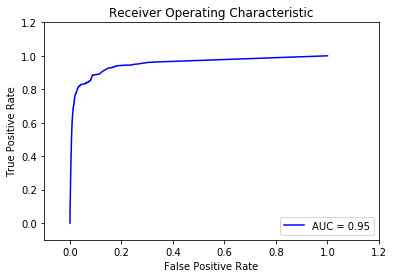

In [9]:
# split for validation
n = int(stacked_train.shape[0] * 0.8)
y_pred, y_val = train_dart_r[n:], y_train[n:]
_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)

Ant-Score: 0.4441207441207441


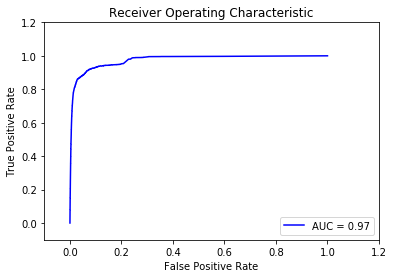

In [10]:
_y = pd.DataFrame(stacked_train[n:])[0]
_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,_y)

Ant-Score: 0.46514566514566513


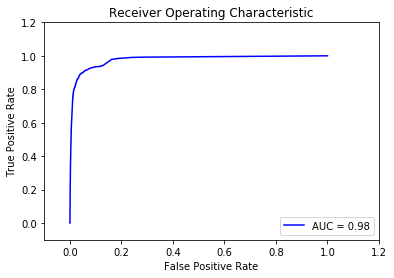

In [11]:
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 scale_pos_weight= scale_pos_weight,
 nthread=40,
 seed=27)


# split for validation
n = int(stacked_train.shape[0] * 0.8)
x_tra, y_tra = stacked_train[:n], y_train[:n]
x_val, y_val = stacked_train[n:], y_train[n:]
model.fit(x_tra,y_tra)
y_pred = pd.DataFrame(model.predict_proba(x_val))[1]

_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)

In [12]:
# predict on test data
final_model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 scale_pos_weight= scale_pos_weight,
 nthread=40,
 seed=27)


final_model.fit(stacked_train, y_train)
test_prediction = final_model.predict_proba(stacked_test)

result=pd.DataFrame()
result['id'] = val_df['id']
result['score'] = pd.DataFrame(test_prediction)[1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84883af198>]],
      dtype=object)

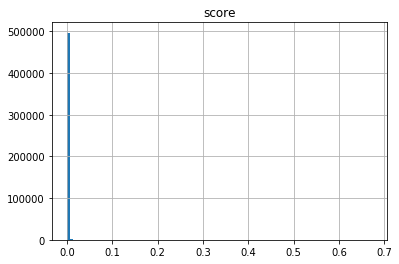

In [13]:
result.hist(bins=100)

In [14]:
len(result[result.score > 0.8])

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8343821908>]],
      dtype=object)

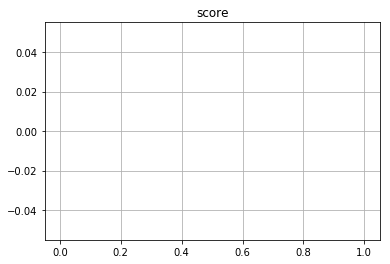

In [15]:
result[result.score > 0.7].hist()

In [16]:
result.to_csv('./submit_0703_1800_1.csv',index=False)